In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import pickle
import glob
from sklearn.utils import shuffle
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import cv2
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
from keras.models import model_from_json
import json

Using TensorFlow backend.


## Load Dataset

(361292800,)
(28226,)


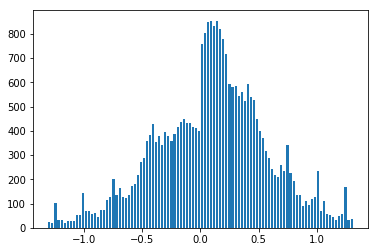

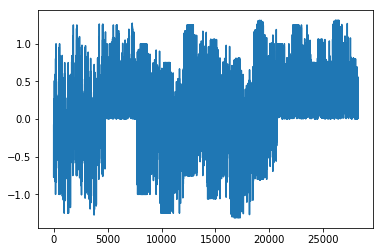

In [2]:
training_img_file2 = 'centerImgs2.p'
training_steer_file2 = 'centerSteering2.p'

training_img_file3 = 'centerImgs3.p'
training_steer_file3 = 'centerSteering3.p'

with open(training_img_file2, mode='rb') as f1:
    train_img = pickle.load(f1)
    
with open(training_steer_file2, mode='rb') as f2:
    train_steer = pickle.load(f2)
    
with open(training_img_file3, mode='rb') as f3:
    train_img1 = pickle.load(f3)
    
with open(training_steer_file3, mode='rb') as f4:
    train_steer1 = pickle.load(f4)

X_train = np.append(train_img, train_img1)
y_train = np.append(train_steer, train_steer1)

print(X_train.shape)
print(y_train.shape)

hist, bins = np.histogram(y_train, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

plt.plot(y_train)
plt.show()

In [3]:
X_train = X_train.reshape(y_train.shape[0], 80, 160, 1)
y_train = y_train.reshape(y_train.shape[0], 1)

print(X_train.shape)
print(y_train.shape)

(28226, 80, 160, 1)
(28226, 1)


## Model Architecture

In [4]:
from keras.layers.core import Dropout

def commaai_model(shape):
    
    model = Sequential()

    model.add(Lambda(lambda x: x/127.5 - 1.,
                input_shape = shape,
                output_shape = shape))
    
    model.add(Convolution2D(16, 8, 8, subsample = (4,4), border_mode = 'same'))
    model.add(ELU(()))
    
    model.add(Convolution2D(32, 5, 5, subsample = (2,2), border_mode = 'same'))
    model.add(ELU(()))    

    model.add(Convolution2D(64, 5, 5, subsample = (2,2), border_mode = 'same'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(ELU(()))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(ELU(()))
    model.add(Dense(1))
    model.add(Activation('softmax'))

    model.compile(optimizer = 'adam', loss = 'mse')
    
    return model

def nvidia_model(shape):
    
    model = Sequential()

    model.add(Lambda(lambda x: x/127.5 - 1.,
                input_shape = shape,
                output_shape = shape))
    
    #conv layers with dropout
    nb_filters = [24, 36, 48, 64, 64]
    kernel_size = [(5, 5), (5, 5), (5, 5), (3, 3), (3, 3)]
    same, valid = ('same', 'valid')
    padding = [valid, valid, valid, valid, valid]
    strides = [(2, 2), (2, 2), (2, 2), (1, 1), (1, 1)]
    dropout = 0.5
    
    for lyr in range(len(nb_filters)):
        model.add(Convolution2D(nb_filters[lyr],
                                kernel_size[lyr][0],
                                kernel_size[lyr][1],
                                subsample = strides[lyr],
                                border_mode = 'valid',
                                activation = 'elu'))

        model.add(Dropout(dropout))
                  
    #flatten layer
    model.add(Flatten())
    
    #fully connected layers with dropout
    neurons = [100, 50, 10]
    for l in range(len(neurons)):
        model.add(Dense(neurons[l], activation = 'elu'))
        model.add(Dropout(dropout))
        
    #logit output - steering angle
    model.add(Dense(1, activation = 'elu', name = 'Out'))
    model.add(Activation('softmax'))

    model.compile(optimizer = 'adam', loss = 'mse')
    
    return model


In [5]:
#%20 percent of training set will splited to validation set

X_train, X_validation, y_train, y_validation = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#X_validation, X_test, y_validation, y_test = sklearn.model_selection.train_test_split(X_validation, y_validation, test_size=0.2, random_state=0)

print(type(X_train),X_train.shape)
print(type(X_validation),X_validation.shape)
#print(type(X_test),X_test.shape)

<class 'numpy.ndarray'> (22580, 80, 160, 1)
<class 'numpy.ndarray'> (5646, 80, 160, 1)


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
from pathlib import Path
import json

def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    
def generateBatch_Train(data, labels, batchSize=10):
    startIdx = 0
    batchCount = len(labels)/batchSize 
    while True: # to make sure we never reach the end
        endIdx = startIdx + batchSize
        batchXCenter = X_train[startIdx:endIdx]
        batchY = y_train[startIdx:endIdx]
        yield batchXCenter, batchY
        startIdx = endIdx
        if startIdx > len(data)-1:
            startIdx = 0

def generateBatch_Val(data, labels, batchSize=10):
    startIdx = 0
    batchCount = len(labels)/batchSize 
    while True: # to make sure we never reach the end
        endIdx = startIdx + batchSize
        batchXCenter = X_validation[startIdx:endIdx]
        batchY = y_validation[startIdx:endIdx]
        yield batchXCenter, batchY
        startIdx = endIdx
        if startIdx > len(data)-1:
            startIdx = 0

shape = (80, 160, 1)

#model = commaai_model(shape)
model = nvidia_model(shape)

numTimes = 1
numEpoch = 1

val_best = 1000

for time in range(numTimes):
    trainGenerator = generateBatch_Train(X_train, y_train, batchSize = 50)
    validGenerator = generateBatch_Val(X_validation, y_validation, batchSize = 50)
    
    samplesPerEpoch = len(y_train)
    nbValSamples = 1000
    
    #history = model.fit(X_train, y_train, nb_epoch=numEpoch, validation_split=0.2)
    history = model.fit_generator(trainGenerator, 
                                  samples_per_epoch = samplesPerEpoch, 
                                  nb_epoch = numEpoch, 
                                  validation_data = validGenerator,
                                  nb_val_samples = nbValSamples)

    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        val_best = val_loss
        fileModelJSON = 'model_best_last.json'
        fileWeights = 'model_best_last.h5'
        save_model(fileModelJSON,fileWeights)
        
    print('Time: ', time + 1)

Epoch 1/1
22580/22580 [==============================] - 279s - loss: 1.0491 - val_loss: 1.0624
Time:  1
